# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">2 hours</span>
* 2. Part B: <span style="color:red;">4 hours</span>
* 3. Part C: <span style="color:red;">2 hours</span>
* 4. Tests: <span style="color:red;">1 hour</span>
* 5. Challenge 1: <span style="color:red;">30 minutes</span>
* 6. Challenge 2: <span style="color:red;">2 hours, 40 minutes</span>
* 7. Write-up: <span style="color:red;">30 minutes</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import timeit
import scipy.linalg as la
import copy
import itertools
from IPython.core.debugger import set_trace

class QRreader(object):
    def __init__(self, file_name):
        """Takes a file name of an image with a QR code and performs various steps to read and store the aligned, cropped, discretized QR code."""
        # Read in the image
        self.orig_QR = cv2.imread(file_name)
        self.QR = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        # Initialize a list containing the unit length ratios
        self.ratio = []
        self.top_left_corner = None
        
        # Get the 3 corner points, the accumulator, and the updated QR image
        self.centers, self.accumulator, self.QR = self.find_corners(self.QR)
        
        # Find the fourth point and store it as a new list
        self.four_pts = self.add_fourth_point(self.centers)
        
        # Use the 4 points to find the Homography transform, and apply it to get a cropped, aligned QR code. 
        self.H = self.get_Homography(self.four_pts)
        self.croppedQR = cv2.warpPerspective(self.QR,self.H,(200,200))
        
        # Discretize the cropped,aligned QR code and store that image
        self.discreteQR = self.discretize()
        
    def process_row(self,row_num, row):
        """Takes an array of black and white pixel counts in a row and returns the corresponding list of coordinates"""
        points = []
        for i in range(0, len(row) - 5):
            ratio1 = row[i]
            # Play with the ratio here to make it more lenient for diagonal images
            if la.norm(np.array(row[i:i+5]) -  np.array([ratio1, ratio1, 3*ratio1, ratio1, ratio1])) < 6:
                points.append((row_num, sum(row[:i + 2]) + row[i+3] * 3/2))
            # Weight closer ones twice as good
            if la.norm(np.array(row[i:i+5]) -  np.array([ratio1, ratio1, 3*ratio1, ratio1, ratio1])) < 3:
                points.append((row_num, sum(row[:i + 2]) + row[i+3] * 3/2))
                self.ratio.append(ratio1)
        return points

    def process_image(self,QR):
        """Searches an image by row for places where a ratio 1:1:3:1:1 can be found between black and white"""

        #Get the shape of the image
        nrows, ncols = QR.shape
        # Create an empty accumulator
        accumulator = np.zeros_like(QR)
        black_count = 0
        white_count = 0
        row_counter = []

        for row in range(nrows):
            current_row = QR[row,:]
            i = 0
            while i < ncols:
                if current_row[i] == 255:
                    while i < ncols and current_row[i] == 255:
                        white_count += 1
                        i += 1
                    row_counter.append(white_count)
                    white_count = 0
                elif current_row[i] == 0:
                    if self.top_left_corner is None:
                        self.top_left_corner = (row,i)
                    while i < ncols and current_row[i] == 0:
                        black_count += 1
                        i += 1 
                    row_counter.append(black_count)
                    black_count = 0
            points = self.process_row(row, row_counter)

            for point in points:
                accumulator[int(point[0]),int(point[1])] += 2
            row_counter = []
        return accumulator

    def find_corners(self,QR):
        """Finds the 3 corners of an image of a QR Code and returns the points as a tuple"""
        # Guarantee that all pixels are black or white
        QR[QR > 127] = 255
        QR[QR <= 127] = 0

        # Process the image horizontally, vertically, and 
        horiz_accumulator = self.process_image(QR)
        vert_accumulator = self.process_image(QR.T).T
        total_accumulator = horiz_accumulator + vert_accumulator

        #Perform Non-Maximal Suppression to find the true centers for the three squares
        square_centers = []
        new_accumulator = copy.deepcopy(total_accumulator)
        center_accumulator = np.zeros_like(total_accumulator)
        #Find the biggest value in the accumulator, and create a threshold based on the overall score
        max_val = np.max(new_accumulator)
        threshold = np.mean(new_accumulator) * 0.8 * (sum(QR.shape))
        #Compute the Centers
        while max_val > threshold:
            cy,cx = np.unravel_index(np.argmax(new_accumulator), new_accumulator.shape)
            if (np.abs(np.mean(new_accumulator[cy-5:cy + 6,cx-5 : cx+ 6]) - np.mean(new_accumulator[cy-2:cy + 3,cx-2 : cx+ 3]))> 0.3):
                center_accumulator[cy,cx] = 255
                square_centers.append((cy,cx))
            new_accumulator[cy-15:cy + 15,cx-15 : cx+ 15] = 0
            max_val = np.max(new_accumulator)
        return square_centers, total_accumulator, QR

    def add_fourth_point(self, centers):
        """Takes 3 QR square center points and finds the corresponding 4th point, appends it to the list and returns"""
        norms = []
        new_centers = []
            
        for combo in itertools.combinations(range(len(centers)),2):
            norms.append((la.norm(np.array(centers[combo[0]]) - np.array(centers[combo[1]])), combo))

        index = np.argmax([val[0] for val in norms])

        far_idx = norms[index][1][0]
        self_idx = norms[index][1][1]
        
        #Identify the missing index to use it
        a = list(range(len(centers)))
        a.remove(far_idx)
        a.remove(self_idx)
        close_idx = a[0]
        
        ####IMPLEMENT CORRECT SORTING WHEN THE QR IS MORE THAN 90 DEGREES ROTATED. RIGHT NOW IT WORKS, BUT IT CAN BE MORE ROBUST###***
        if centers[self_idx][1] > centers[far_idx][1]:
            self_idx, far_idx = far_idx, self_idx
        
        #Get the new x and y coordinates for the fourth point, add it to the centers and return the list
        new_x = centers[self_idx][1] + centers[far_idx][1] - centers[close_idx][1]
        new_y = centers[self_idx][0] + centers[far_idx][0] - centers[close_idx][0]
        extra_point = (new_y, new_x)
        
        new_centers.append(centers[close_idx]) # top left
        new_centers.append(centers[far_idx]) # top right
        new_centers.append(centers[self_idx]) # bottom left
        new_centers.append(extra_point)
        
        return new_centers
    
    def get_Homography(self, srcPts):
        """Gets the homography that will transform the warped QR code to a cropped aligned QR code"""
        h,w = 200,200
        #Get the right ordering of the points
        src_pts = np.array([np.array([p[1],p[0]]) for p in srcPts])
        ratio = np.mean(self.ratio)
        dy,dx = 4*ratio, 4*ratio
        dst_pts = np.array([[0+dy,0+dx],[h-dy,0+dx],[0+dy,w-dx],[h-dy,w-dx]])
        H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)[0]
        return H
    
    def display_corners(self):
        """Displays the 3 centers of the squares on the original image of the QR Code"""
        
        image = self.orig_QR.copy()
        for point in self.centers:
            image[point[0]][point[1]] = (255,0,0)
        plt.title("3 Corners")
        plt.imshow(image)
#         plt.axis("off")
        plt.show()
    
    def display_four_pts(self):
        """Displays the 4 pointson the original image of the QR Code"""
        image = self.orig_QR.copy()
        for point in self.four_pts:
            image[point[0]][point[1]] = (255,0,0)
        plt.title("4 Points")
        plt.imshow(image)
#         plt.axis("off")
        plt.show()
        
    def display_cropped_QR(self):
        """Displays the aligned and cropped QR Code after processing has been done"""
        plt.title("Cropped and Aligned")
        plt.imshow(self.croppedQR, cmap="gray")
#         plt.axis("off")
        plt.show()
        
    def display_discrete_QR(self):
        """Displays the discretized version of the QR code, which can be decoded"""
        plt.title("Discrete QR Code")
        plt.imshow(self.discreteQR, cmap="gray")
#         plt.axis("off")
        plt.show()
    
    def display_all(self):
        """Displays the 4 points found, the cropped and aligned image and the discretized image"""
        #Display the 4 Points found
        plt.subplot(1,4,2)
        image = self.orig_QR.copy()
        for point in self.four_pts:
            image[point[0]][point[1]] = (255,0,0)
        plt.title("4 Points")
        plt.imshow(image)
        
        #Display the Cropped and Aligned Image
        plt.subplot(1,4,3)
        plt.title("Cropped and Aligned")
        plt.imshow(self.croppedQR, cmap="gray")
        
        #Display the Discretized Image
        plt.subplot(1,4,4)
        plt.title("Discrete QR Code")
        plt.imshow(self.discreteQR, cmap="gray")
        plt.show()
        
    def discretize(self):
        """Performs a discretization of the cropped and aligned QR code by search for appropriate size where the timing marks alternate"""
        for n in range(21,34,4):
            img = cv2.resize(self.croppedQR.copy(), (n,n))
            img[img <= 127] = 0
            img[img > 127] = 1
            if la.norm(img[6,7:-7] - np.array([r%2 for r in range(1,n)])[6:-7]) < 1:
                return img
        

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

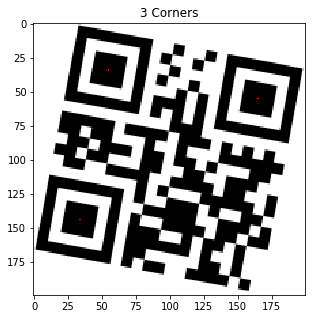

In [2]:
#Build a QRreader, and display the corners
plt.rcParams['figure.figsize'] = [5,5]
reader = QRreader("QR_codes/test2.png")
reader.display_corners()

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

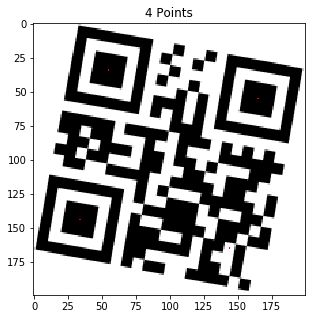

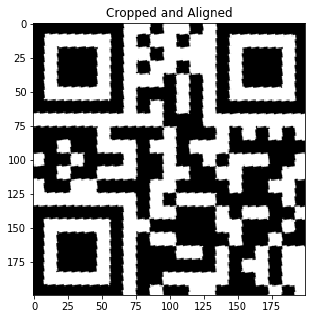

In [3]:
#Build a QRreader, and display the 4 points, and also the aligned and cropped image
reader = QRreader("QR_codes/test2.png")
plt.rcParams['figure.figsize'] = [5,5]
reader.display_four_pts()
reader.display_cropped_QR()

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


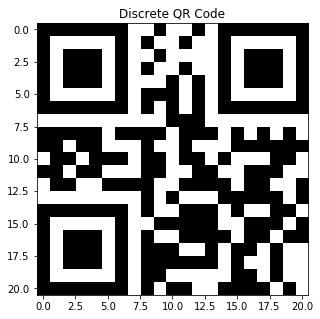

In [4]:
# Display the discretized QR Code
plt.rcParams['figure.figsize'] = [5,5]
reader = QRreader("QR_codes/test2.png")
reader.display_discrete_QR()

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [5]:
# Import the decoder, and print the output URL
from decoder import decode
reader = QRreader("QR_codes/test2.png")        
output_url = decode(reader.discreteQR)
print(output_url)

http://byu.edu


## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

Test1 URL: 
http://byu.edu 



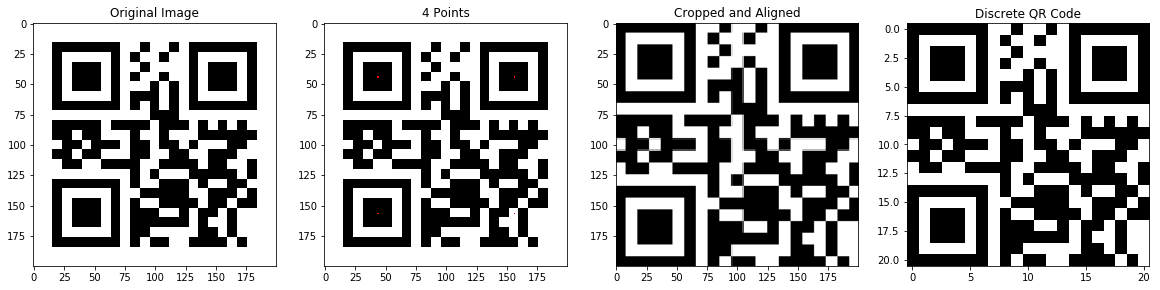

In [6]:
#Adjust the figures so each one has enough space
from decoder import decode
plt.rcParams['figure.figsize'] = [20,20]
#Display the progression of test1 and print test1's URL
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/test1.png")
print("Test1 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

Test2 URL: 
http://byu.edu 



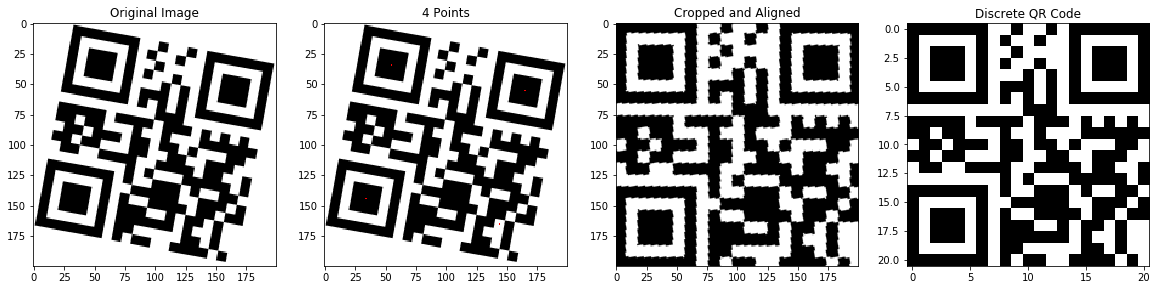

In [7]:
#Display the progression of test2 and print test2's URL
image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/test2.png")
print("Test2 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

Test3 URL: 
http://byu.edu 



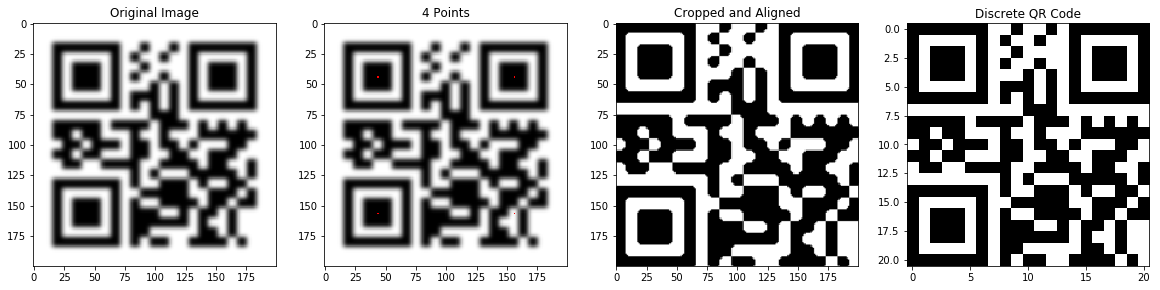

In [8]:
#Display the progression of test3 and print test3's URL
image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/test3.png")
print("Test3 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

Test4 URL: 
http://byu.edu 



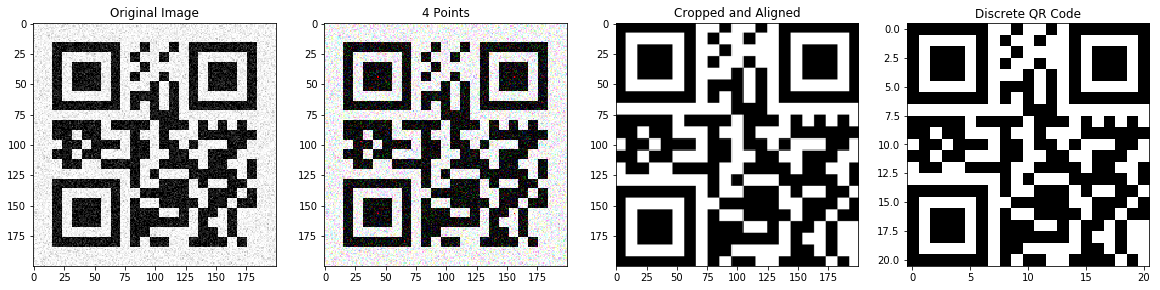

In [9]:
#Display the progression of test4 and print test4's URL
image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/test4.png")
print("Test4 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

Test5 URL: 
http://DataGenetics.com 



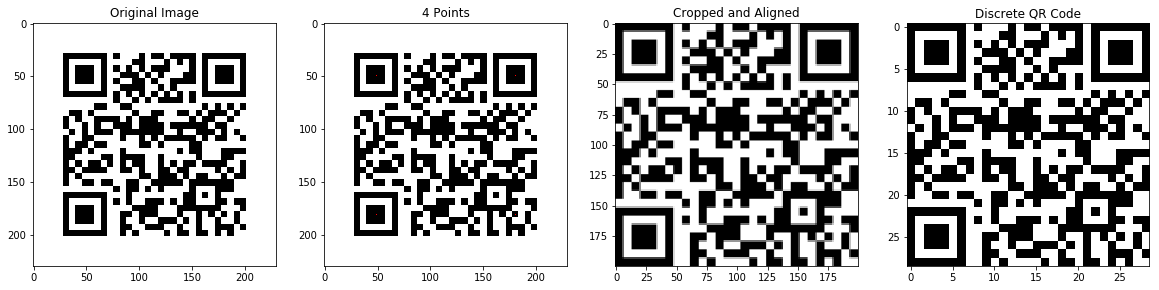

In [10]:
#Display the progression of test5 and print test5's URL
image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/test5.png")
print("Test5 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



Challenge1 URL: 
http://byu.edu 



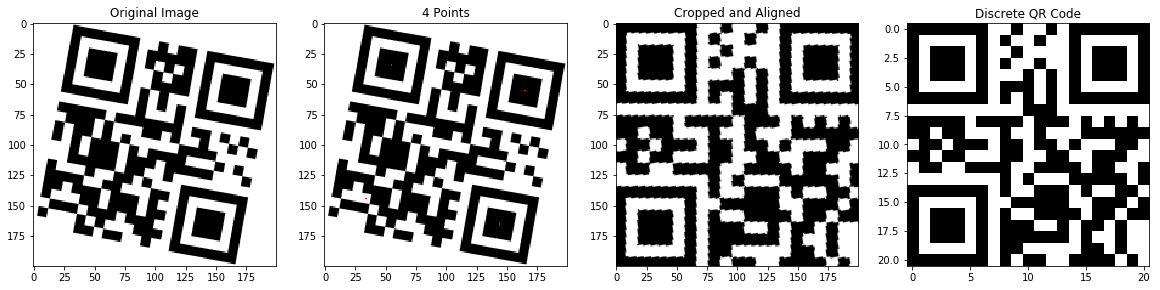

In [11]:
#Display the progression of Challenge1 and print Challenge1's URL
image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/challenge1.png")
print("Challenge1 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

Challenge3 URL: 
http://byu.edu 



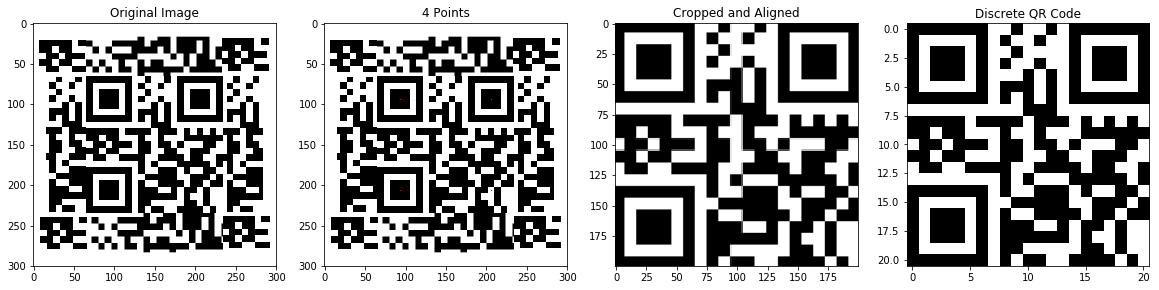

In [12]:
#Display the progression of Challenge3 and print Challenge3's URL
image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
reader = QRreader("QR_codes/challenge3.png")
print("Challenge3 URL: ")
output_url = decode(reader.discreteQR)
print(output_url, "\n")
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(image,cmap="gray")
reader.display_all()

In [13]:
#Code for decoding the barcode in challenge5
class BarcodeReader(object):
    def __init__(self, file_name):
        self.QR = cv2.imread("QR_codes/challenge5.png", cv2.IMREAD_GRAYSCALE)
        self.bin_widths_128 = {'122231': '.', '121124':'a','121421': 'b','141122': 'c', 
                      '141221':'d','112214': 'e','112412': 'f','122114':'g',
                      '122411':'h', '142112':'i', '142211':'j', '241211':'k', 
                      '221114':'l', '413111':'m','241112':'n','134111':'o',
                      '111242':'p','121142':'q','121241':'r','114212':'s',
                      '124112':'t','124211':'u','411212':'v','421112':'w',
                      '421211':'x','212141':'y','214121':'z', '233111':'Stop'}
        self.bar = self.process_bar(self.QR)
        self.URL = self.bar_decode(self.bar)
        
    def process_bar(self,QR):
        """Takes a barcode image and returns a list containing the black/white count of a bar"""
        nrows,ncols = QR.shape
        white_count = 0
        black_count = 0
        bar = []

        #Process one row of the bar since each row will be equal
        for row in range(1):
            current_row = QR[row,:]
            i = 0
            while i < ncols:
                if current_row[i] == 255:
                    while i < ncols and current_row[i] == 255:
                        white_count += 1
                        i += 1
                    bar.append(white_count)
                    white_count = 0
                elif current_row[i] == 0:
                    while i < ncols and current_row[i] == 0:
                        black_count += 1
                        i += 1 
                    bar.append(black_count)
                    black_count = 0
            return bar

    def bar_decode(self,bar):
        """Takes a barcode count of black/whites in a row, and returns the associated URL"""
        #Get our code128 dictionary
        c128 = []
        URL = "http://"
        #Only check the second to the end, since the first will be the start code
        for i in range(1,len(bar), 6):
            a = [max(1,round(x/2)) for x in bar[i:i+6]]
            c128.append("".join([str(c) for c in a]))
        for letter in c128:
            if letter in self.bin_widths_128.keys() and self.bin_widths_128[letter] == "Stop":
                break
            elif letter in self.bin_widths_128.keys():
                URL += self.bin_widths_128[letter]
        return URL
    
    def display_bar(self):
        """Displays the barcode read into the reader"""
        plt.imshow(self.QR,cmap="gray");
        plt.show()
        

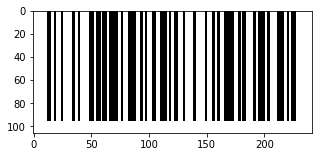

Challenge5 URL:
http://byu.edu


In [14]:
#Display the processing of Challenge5, and Challenge5's URL
reader = BarcodeReader("QR_codes/challenge5.png")
plt.rcParams['figure.figsize'] = [5,5]
reader.display_bar()
print("Challenge5 URL:")
print(reader.URL)


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

I think the part of this lab that was the most difficult was figuring out how to transform the images after finding the four points. I ended up using 4 unit lengths as the centers away from the edges of a blank image to use as my destination points in the homography, which worked pretty well for eah of the tests, and the two challenge images I attempted. I also think another thing that was hard about the lab was that it was hard to decide how I wanted to implement finding the corners, so getting started was a little rough since I would do something one way, and then go back on it because I thought of a better way to implement it, which happened a couple times. But once I got that working, the rest of the lab implementation was pretty simple (besides deciding the transforming points which I already talked about).

I decided to do challenge 1 and challenge 3. 
For challenge 1, I decided to sort the points that I found based on their relative distance, knowing that the relative distance between the two opposite corners would be larger than their relative distance to the middle corner that was supposed to be in the top left. That way, I would be able to know which point represented the top left corner, and then I compared the top right and the bottom left points to make sure that they were in the right spot, and if not, I swapped their order so that I would have them in the right order when I built my homography. In doing so, I made sure that if the image was too far rotated, then the homography would take care of the number of rotations required instead of stacking the the same transformation homography to get more rotations.

For challenge 3, my algorithm worked pretty well without much additional fine tuning. I think this is because there wasn't much of an effect that the extra parts around the QR code were having on my algorithm. It didn't really affect how I found points, which I did by vertical and horizontal scanning, and then two find the homography, I used the unit lengths on a blank canvas instead of finding the first black top corner, so the challenge 3 image was actually just working without any extra work on my part.

For challenge 5, I created a whole new class that has its own methods for processing barcodes. I understand that it is possible and pretty simple to include this image and the associated methods to process it all into one class, and change the constructor for that super class to not run the algorithm, but only include the similarities and then make two separate functions to run the algorithm to process either a bar or a QR code, but I figured creating a new class to do that would be the simpler to separate them. I processed a single row by counting the lengths of each change in black and white, and converted each group of 6 changes into code 128. Then I used the dictionary of code 128 values to ascii characters to convert the code128 values into a URL, and tacked on http:// to the front to make it usable. 

For my general algorithm, I read in the image as grayscale, clipped the image to 0 and 255, and then processed each row to check for a 1:1:3:1:1 ratio. I did that horizontally and vertically, and I was able to use those to build an accumulator where I took the points that had the highest accumulation, which were the centers of the squares. I used a normed difference threshold to allow for a bit of variation so it didn't require an exact ratio, but close enough. Then, after finding the 3 centers, I computed the fourth center by finding the top left corner, and using the distances betwen the other two to get their distances from the fourth point. Those points I stored, and used to find a homography that would map those points appropriately to a blank canvas 4 unit lengths away from each of the edges/corners of a cropped/aligned image. Using that aligned and cropped image, I discretized the image by checking various sizes until the appropriate size had the timing marks alernating. That seemed to work pretty well. 

I think some improvements to the lab could be to have a bit more direction of what kinds of things can be done on the other challenge problems. It seems to me like not many people have gotten challenge 2,4, or 5. I started working on them, but couldn't get them to work out with my current algorithm pipeline. I think If I worked on them individually, I could get them to recognize it, and process it correctly, but it seems to need a lot more extra work than the two challenges I did complete. Besides that, I did like freedom to implement things how we wanted, and it helped me feel like I was developing my own strategy. I wish my code would be more robust to other kinds of QR codes, but for now, I think that it's good enough. I think maybe it would be good to discuss possible packages or other things that people used to solve this one next year so people have a better idea of the kinds of strategies/methods that are available.

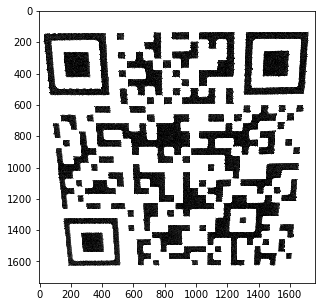

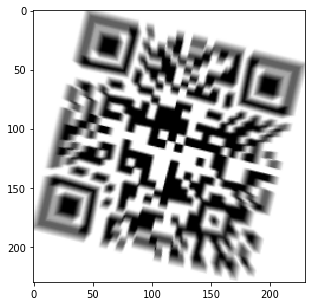

In [15]:
#Unsolved challenges:
image = cv2.imread("QR_codes/challenge2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()